# **Accent Removal**

## **Abstract**
   
This project explores accent removal in English speech while preserving speaker identity, addressing the challenge of limited paired accented and non-accented speech samples from the same speaker. Using a dataset of Indian-accented English recordings, synthetic American-accented versions of the same sentences were generated for training. A two-stage approach was implemented: first, a Wav2Vec2-based classifier distinguished accented from non-accented speech, which then guided an EnCodec-based generator to produce accent-neutralized speech. Speaker identity preservation was enforced using ECAPA-TDNN embeddings. An alternative method involving SpeechTokenizer’s codebook manipulation was attempted but proved ineffective. Preliminary results suggest that the discriminator-guided approach shows promise in reducing accent cues while maintaining speaker similarity, though challenges remain in achieving naturalness and complete accent removal. The work highlights the potential of leveraging self-supervised representations and adversarial training for accent conversion, but underscores the need for better disentanglement techniques between accent and speaker attributes.

### **Introduction**  

Accent conversion is a challenging yet impactful task in speech processing, with applications ranging from improving speech intelligibility to enhancing language learning tools. The core problem lies in modifying a speaker’s accent—such as converting Indian-accented English to a more neutral American accent—while preserving the speaker’s unique voice characteristics. However, the scarcity of parallel data, where the same speaker utters identical sentences in different accents, poses a significant hurdle for supervised learning approaches. This limitation has spurred research into alternative techniques that minimize reliance on paired data, such as leveraging intermediate speech representations or incorporating articulatory features.  

Recent work has explored innovative solutions to this problem. One promising approach [1] involves semantic token-based conversion, where accent transformation is performed at a linguistic representation level before synthesizing speech in the target accent. This method reduces dependency on parallel data by decoupling the conversion and synthesis stages. Another line of research [2] integrates articulatory features, such as tract variables, into the conversion pipeline. These features capture subtle pronunciation differences tied to accents, improving the model’s ability to modify accent-specific traits while retaining speaker identity. While effective, these methods often require complex multi-stage pipelines or auxiliary systems to extract articulatory features.  

In this work, we propose a more streamlined approach that leverages self-supervised learning (SSL) and adversarial training to disentangle accent from speaker identity directly from speech waveforms. Our method employs a Wav2Vec2-based discriminator trained to distinguish between accented and non-accented speech. This discriminator then guides a SpeechTokenizer model, trained with a combination of adversarial loss, ECAPA-TDNN speaker similarity loss, and reconstruction loss, to generate accent-neutral speech while preserving the original speaker’s voice. By operating entirely in the audio domain, our framework eliminates the need for parallel data, text transcriptions, or additional feature extraction systems.  

Preliminary experiments on Indian-English speech demonstrate that our approach effectively reduces accent cues while maintaining speaker similarity, though challenges remain in achieving fully natural-sounding output. The adversarial training strategy proves particularly effective, outperforming an alternative attempt to manipulate SpeechTokenizer’s codebooks for accent removal. These results highlight the potential of SSL representations and adversarial learning for low-resource accent conversion. Moving forward, integrating insights from semantic token-based conversion or articulatory feature modeling could further enhance the naturalness and robustness of the system.  

This work contributes to the growing body of research on accent conversion by demonstrating the viability of adversarial SSL-based methods in scenarios with limited parallel data. Our findings suggest that combining discriminative and generative training with speaker-preserving objectives offers a promising path toward practical accent conversion systems. Future directions include refining the disentanglement of accent and speaker features and exploring hybrid approaches that merge the strengths of SSL with articulatory or semantic representations.

## **Methodology**
Describe the important steps you took to achieve your goal. Focus more on the most important steps (preprocessing, extra features, model aspects) that turned out to be important. Mention the original aspects of the project and state how they relate to existing work.

In this section, you can add **text** and **figures**. For instance, it is strongly suggested to add a picture of the best machine learning model that you implemented to solve your problem (and describe it).


## **Experimental Setup**
Describe the datasets used for your experiments. List the machine learning techniques used to solve your problem and report the corresponding hyperparameters.

In this section, you can add **text**, **tables**, and **figures**.

### Plan

The accent classification pipeline processes raw audio through a conv-frozen Wav2Vec2 model (wav2vec2-base-960h variant) [3] to extract 768-dimensional frame-level features. These features are averaged temporally before passing through an MLP classifier. The output layer uses softmax to predict binary accent labels (accented vs non-accented). During adversarial training, this network provides gradient signals to guide accent removal while remaining fixed after initial pretraining.

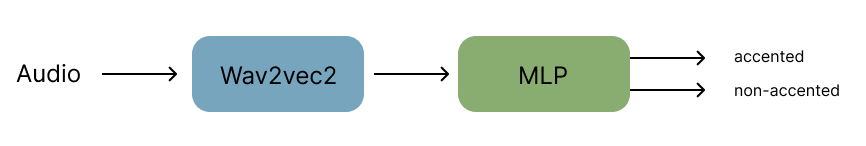

The modified SpeechTokenizer [4] encoder processes input audio through its 8-layer vector-quantized variational autoencoder (VQ-VAE) architecture, with special conditioning on the first two codebooks.

- **Codebook 1 (Accent Modeling)**: An MLP head trained with negative log likelihood loss to predict accent presence using the discriminator's labels. During inference, this codebook is masked to remove accent characteristics.

- **Codebook 2 (Speaker Preservation)**: A parallel MLP head trained with negative log likelihood (N-way softmax) using speaker IDs derived from data manifest.

Implementation Details:

Base SpeechTokenizer remains unchanged beyond first two codebooks. Only the encoder is trained.

Gradient stops between codebook heads and main VQ-VAE

Multi-task training with loss = λ₁L_accent + λ₂L_speaker


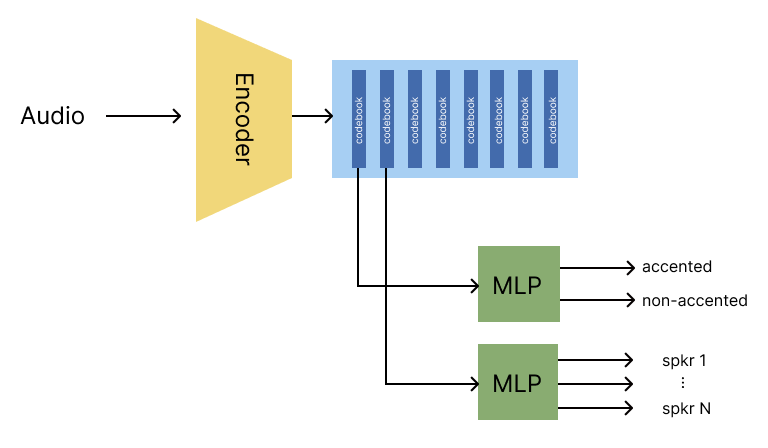

The complete accent conversion system combines:

- Adversarial Feedback Loop: The frozen Wav2Vec2 discriminator backpropagates through the SpeechTokenizer decoder to minimize accent presence

- Speaker Consistency: ECAPA-TDNN embeddings compared between input/output using cosine similarity loss

- Audio Reconstruction: MSE loss on mel-spectrograms ensures output quality

- Dynamic loss weighting: λ₁L_accent + λ₂L_speaker + λ₃L_recon

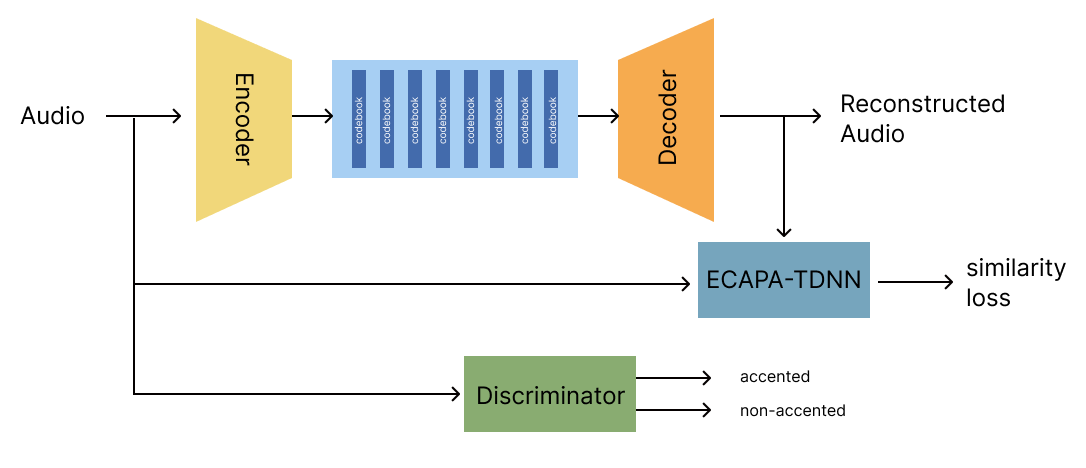

### Dataset

#### Data Exploration


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import numpy as np

parquet_dir = "/content/data"
all_categorical_counts = {}
all_numerical_stats = []
sentence_lengths = []
total_rows = 0

parquet_files = [f for f in os.listdir(parquet_dir) if f.endswith(".parquet")]

if not parquet_files:
    print(f"No parquet files found in the directory: {parquet_dir}")
else:
    print("Processing parquet files:")
    for file_name in parquet_files:
        file_path = os.path.join(parquet_dir, file_name)
        try:
            pdf = pd.read_parquet(file_path)
            num_rows = len(pdf)
            total_rows += num_rows

            categorical_cols = ['age', 'gender', 'accents']
            for col in categorical_cols:
                if col in pdf.columns:
                    if col not in all_categorical_counts:
                        all_categorical_counts[col] = pd.Series(dtype='int64')
                    all_categorical_counts[col] = all_categorical_counts[col].add(pdf[col].value_counts(), fill_value=0)

            if 'sentence' in pdf.columns:
                sentence_lengths.extend(pdf['sentence'].str.len().tolist())

            del pdf  # Release memory
        except Exception as e:
            print(f"Error reading parquet file {file_name}: {e}")

    print("\n--- Combined Value Counts and Distributions for Categorical Columns ---")
    for col, counts in all_categorical_counts.items():
        print(f"\nValue counts for column '{col}':")
        print(counts)

        plt.figure(figsize=(10, 6))
        top_n = 20
        top_counts = counts.nlargest(top_n)
        sns.barplot(x=top_counts.values, y=top_counts.index)
        plt.title(f"Distribution of Top {top_n} '{col}'")
        plt.xlabel("Count")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

    print("\n--- Sentence Length Analysis ---")
    if sentence_lengths:
        sentence_lengths_series = pd.Series(sentence_lengths)
        print(sentence_lengths_series.describe())
        plt.figure(figsize=(10, 6))
        sns.histplot(sentence_lengths_series, bins=50, kde=True)
        plt.title("Distribution of Sentence Length")
        plt.xlabel("Sentence Length")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

```--- Combined Value Counts and Distributions for Categorical Columns ---```

```
Value counts for column 'age':
age
              5655.0
fifties        568.0
fourties      9609.0
seventies        8.0
sixties        235.0
teens         4361.0
thirties      9745.0
twenties     61329.0
dtype: float64
```
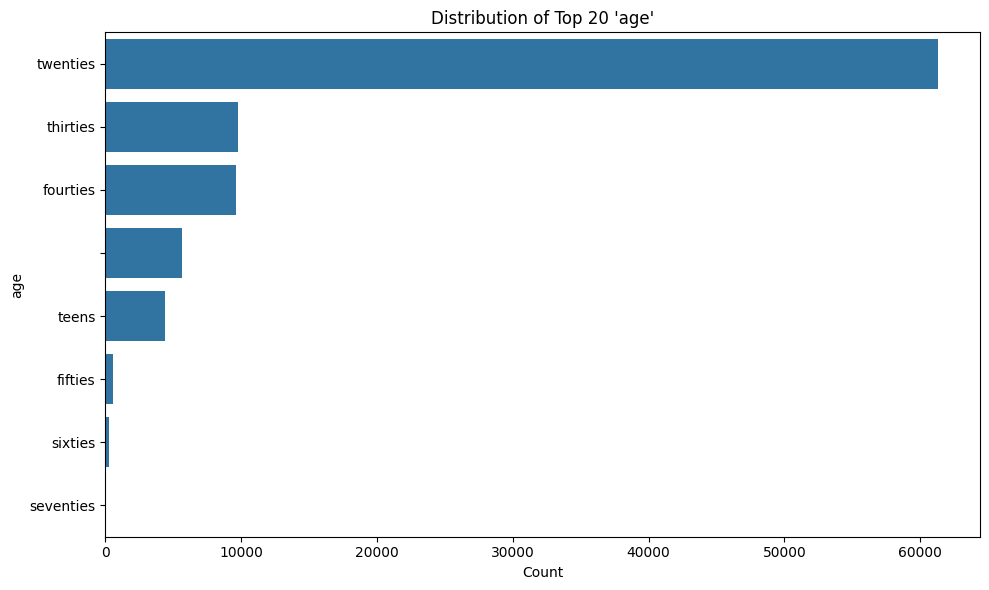

```
Value counts for column 'gender':
gender
           5672.0
female    34856.0
male      50970.0
other        12.0
dtype: float64
```
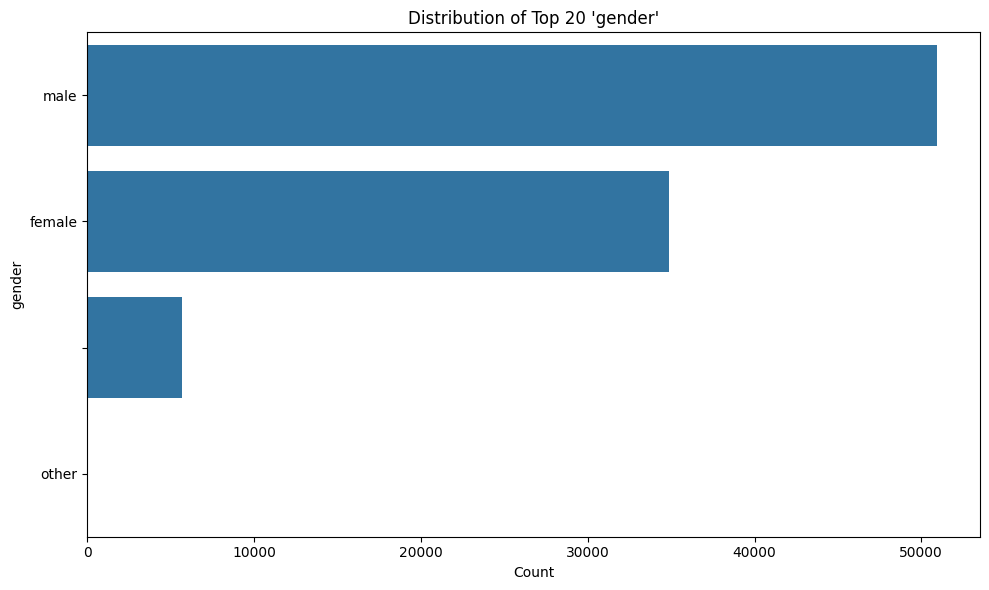

```
Value counts for column 'accents':
accents
East Indian                                                                                                                                                8.0
I think mine accent is influenced by Indian Accent ,Yes Please. ,India and South Asia (India, Pakistan, Sri Lanka)                                         5.0
India and South Asia (India, Pakistan, Sri Lanka)                                                                                                      90781.0
India and South Asia (India, Pakistan, Sri Lanka),Basic                                                                                                    3.0
India and South Asia (India, Pakistan, Sri Lanka),Canadian English                                                                                        22.0
India and South Asia (India, Pakistan, Sri Lanka),England English                                                                                        105.0
India and South Asia (India, Pakistan, Sri Lanka),England English,United States English                                                                    5.0
India and South Asia (India, Pakistan, Sri Lanka),Indian with a tinge of an RP accent                                                                     12.0
India and South Asia (India, Pakistan, Sri Lanka),International Indian Accent                                                                             40.0
India and South Asia (India, Pakistan, Sri Lanka),Singaporean English                                                                                    115.0
India and South Asia (India, Pakistan, Sri Lanka),United States English                                                                                   10.0
India and South Asia (India, Pakistan, Sri Lanka),United States English,England English                                                                   12.0
India and South Asia (India, Pakistan, Sri Lanka),bangladesh                                                                                              16.0
India and South Asia (India, Pakistan, Sri Lanka),try to maintain originality                                                                            106.0
South Indian                                                                                                                                             112.0
United States English,Australian English,England English,New Zealand English,India and South Asia (India, Pakistan, Sri Lanka),international,Slovak       10.0
United States English,England English,India and South Asia (India, Pakistan, Sri Lanka)                                                                   35.0
United States English,India and South Asia (India, Pakistan, Sri Lanka)                                                                                   90.0
West Indian                                                                                                                                               14.0
bangladesh,India and South Asia (India, Pakistan, Sri Lanka)                                                                                               9.0
dtype: float64
```

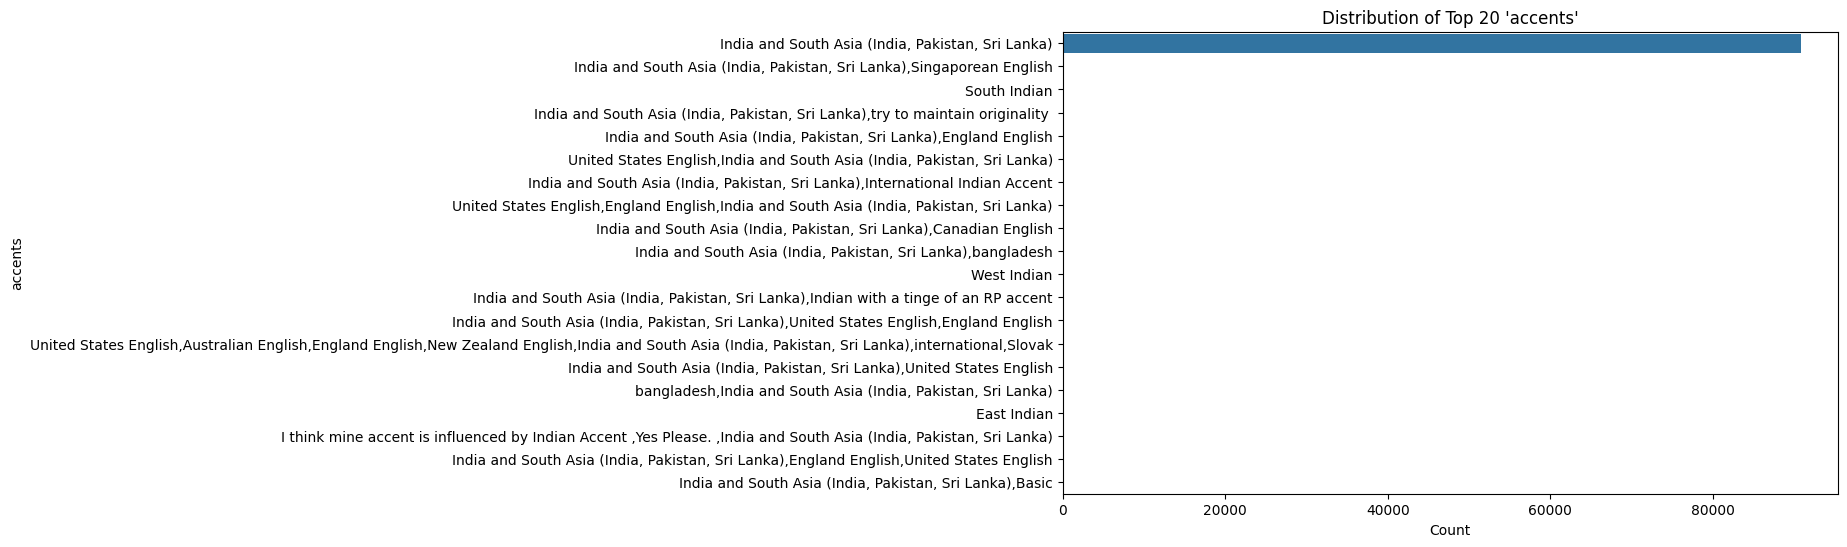



```
count    91510.000000
mean        62.876265
std         18.428933
min          4.000000
25%         50.000000
50%         64.000000
75%         76.000000
max        178.000000
dtype: float64
```

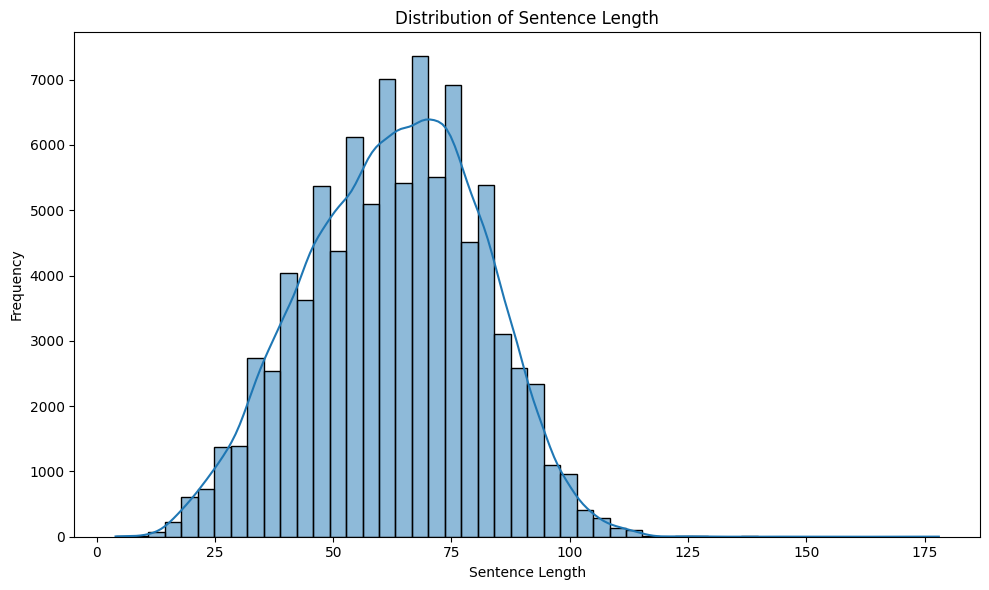

### Data Manifest Preparation

In [ ]:
import os
from huggingface_hub import list_repo_files, hf_hub_download
from tqdm import tqdm

repo_id = "WillHeld/india_accent_cv"
output_dir = "/content"
os.makedirs(output_dir, exist_ok=True)

try:
    all_files = list_repo_files(repo_id=repo_id, repo_type="dataset")
    parquet_files = [f for f in all_files if f.endswith(".parquet")]

    print(f"Found {len(parquet_files)} parquet files in the repository:")
    for file in parquet_files:
        print(f"- {file}")

    print("\nDownloading parquet files:")
    for file in tqdm(parquet_files):
        output_path = os.path.join(output_dir, file.replace("/", "_"))
        try:
            downloaded_file = hf_hub_download(repo_id=repo_id, filename=file, repo_type="dataset", local_dir=output_dir, local_dir_use_symlinks=False)

        except Exception as e:
            print(f"Error downloading {file}: {e}")

    print("\nParquet file download complete!")

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import os
import pandas as pd
import json
import random
import torchaudio
from io import BytesIO
import uuid
import time

# Define directories
dataset_dir = "/content/data"
audio_save_dir = os.path.join("/content", "audio_files")
checkpoint_file = os.path.join(dataset_dir, "processing_checkpoint.json")
save_interval = 60 * 15
start_time = time.time()

# Ensure audio directory exists
os.makedirs(audio_save_dir, exist_ok=True)

# Find all Parquet files in dataset directory
parquet_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".parquet")]

# Try to load existing checkpoint
if os.path.exists(checkpoint_file):
    print(f"Resuming from checkpoint: {checkpoint_file}")
    with open(checkpoint_file, 'r') as f:
        checkpoint_data = json.load(f)
        json_dict = checkpoint_data.get('json_dict', {})
        processed_files = set(checkpoint_data.get('processed_files', []))
        processed_count = len(json_dict)
else:
    json_dict = {}
    processed_files = set()
    processed_count = 0
    print("Starting processing from scratch.")

total_parquet_files = len(parquet_files)

for i, parquet_file in enumerate(parquet_files):
    filename = os.path.basename(parquet_file)
    if filename in processed_files:
        print(f"Skipping already fully processed file: {parquet_file}")
        continue

    print(f"Processing ({i+1}/{total_parquet_files}): {parquet_file}")
    temp_json_dict = {}  # Temporary dictionary for entries from this file
    processed_current_file = True

    try:
        dataset = pd.read_parquet(parquet_file)

        for index, row in dataset.iterrows():
            client_id = row["client_id"]
            unique_id = f"{client_id}-{index}"

            try:
                audio_bytes = row["audio"]["bytes"]
                audio_filepath = os.path.join(audio_save_dir, f"{unique_id}.wav")

                with open(audio_filepath, "wb") as f:
                    f.write(audio_bytes)

                audio_waveform, sample_rate = torchaudio.load(BytesIO(audio_bytes))
                duration = audio_waveform.shape[1] / sample_rate

                temp_json_dict[unique_id] = {
                    "path": audio_filepath,
                    "sentence": row["sentence"],
                    "speaker": row["client_id"],
                    "accent": "accented",
                    "length": duration
                }

            except Exception as e:
                print(f"Error processing sample with client_id {client_id} in {filename}: {e}")
                processed_current_file = False
                break  # Stop processing this file if an error occurs

        if processed_current_file:
            json_dict.update(temp_json_dict)
            processed_files.add(filename)
            print(f"Successfully processed and added entries from: {parquet_file}")

    except Exception as e:
        print(f"Error reading Parquet file {parquet_file}: {e}")
        processed_current_file = False

    # Periodically save progress (only the set of fully processed files and the accumulated json_dict)
    if (time.time() - start_time > save_interval):
        print("Saving checkpoint...")
        checkpoint_data = {
            'json_dict': json_dict,
            'processed_files': list(processed_files)
        }
        with open(checkpoint_file, 'w') as f:
            json.dump(checkpoint_data, f, indent=4)
        start_time = time.time()

print("Saving final JSON files...")
items = list(json_dict.items())
random.shuffle(items)

train_split = int(0.8 * len(items))
test_split = int(0.9 * len(items))

train_data = dict(items[:train_split])
test_data = dict(items[train_split:test_split])
val_data = dict(items[test_split:])

with open(os.path.join(dataset_dir, "train.json"), "w") as f:
    json.dump(train_data, f, indent=4)
with open(os.path.join(dataset_dir, "test.json"), "w") as f:
    json.dump(test_data, f, indent=4)
with open(os.path.join(dataset_dir, "valid.json"), "w") as f:
    json.dump(val_data, f, indent=4)

if os.path.exists(checkpoint_file):
    os.remove(checkpoint_file)
    print(f"Removed checkpoint file: {checkpoint_file}")

print(f"Processed {len(parquet_files)} Parquet files")
print(f"Total entries created: {len(json_dict)}")
print(f"Train: {len(train_data)} samples")
print(f"Test: {len(test_data)} samples")
print(f"Validation: {len(val_data)} samples")

In [ ]:
import os
import pandas as pd

dataset_dir = "/content/data"
audio_save_dir = os.path.join("/content", "audio_files")

# Ensure audio directory exists
os.makedirs(audio_save_dir, exist_ok=True)

parquet_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".parquet")]

total_audio_files = 0

for parquet_file in parquet_files:
    try:
        print("Reading parquet file:", parquet_file)

        df = pd.read_parquet(parquet_file)
        total_audio_files += len(df)
    except Exception as e:
        print(f"Error reading Parquet file {parquet_file}: {e}")

print(f"Total number of audio files found in all .parquet files: {total_audio_files}")

In [ ]:
def extract_sentences(json_path):
    """
    Parses a JSON file and returns all the sentences inside.

    Args:
    - json_path (str): Path to the JSON file.

    Returns:
    - list of str: List of extracted sentences.
    """
    with open(json_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return [entry["sentence"] for entry in data.values() if "sentence" in entry]

test_sentences = extract_sentences("data/test.json")
train_sentences = extract_sentences("data/train.json")
valid_sentences = extract_sentences("data/valid.json")

To generate neutral-accented audio samples for training, I used the Kokoro text-to-speech (TTS) model [5] in conjunction with espeak-ng for phoneme conversion. This setup allowed me to synthesize standardized, neutral-accented speech for the same sentences found in my original dataset. The generated audio was then paired with the original accented recordings to train a multi-layer perceptron (MLP) classifier to distinguish between accented and non-accented speech patterns.

In [ ]:
!pip install -q kokoro>=0.9.2 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1

In [ ]:
class TextToSpeechGenerator:
    def __init__(self, lang_code='a', output_dir='output_audio'):
        """Initialize the TextToSpeechGenerator with language and voice preferences."""
        self.pipeline = KPipeline(lang_code=lang_code)
        self.output_dir = output_dir
        self.voices = ['af_alloy', 'af_aoede', 'af_bella', 'af_heart', 'af_jessica', 'af_kore', 'af_nicole',
                      'af_nova', 'af_river', 'af_sarah', 'af_sky', 'am_adam', 'am_echo', 'am_eric', 'am_fenrir',
                      'am_liam', 'am_michael', 'am_onyx', 'am_puck', 'am_santa']
        os.makedirs(self.output_dir, exist_ok=True)

    def generate_audio_from_text(self, texts):
        """
        Generates speech from a list of text inputs and saves them in a given directory.

        Args:
        - texts (list of str): List of text inputs for speech generation.

        Returns:
        - dict: A dictionary mapping each text input to its generated audio file path.
        """
        results = []

        for i, text in enumerate(texts):
            voice = random.choice(self.voices)
            filename = os.path.join(self.output_dir, f"generated_audio_{i}.wav")

            generator = self.pipeline(text, voice=voice)
            for _, _, audio in generator:
                sf.write(filename, audio, 24000)
                results.append({
                    'text': text,
                    'audio_file': filename,
                    'voice': voice
                })
                break

        print("Done Generating Audio Files")

        return results

In [ ]:
test_tts_generator = TextToSpeechGenerator(lang_code='a', output_dir="audio_filess/generated/test/")
test_audio_mapping = test_tts_generator.generate_audio_from_text(test_sentences)

train_tts_generator = TextToSpeechGenerator(lang_code='a', output_dir="audio_filess/generated/train/")
train_audio_mapping = train_tts_generator.generate_audio_from_text(train_sentences)

valid_tts_generator = TextToSpeechGenerator(lang_code='a', output_dir="audio_filess/generated/valid/")
valid_audio_mapping = valid_tts_generator.generate_audio_from_text(valid_sentences)

In [ ]:
!cp data/train.json data/train_original_dataset.json
!cp data/test.json data/test_original_dataset.json
!cp data/valid.json data/valid_original_dataset.json

In [ ]:
import json
import torchaudio

def add_json_object(json_path, new_data):
    """
    Adds new JSON objects to an existing JSON file.

    Args:
    - json_path (str): Path to the JSON file.
    - new_data (list of dict): List of dictionaries containing text, audio file, and voice information.
                              Format: [{'text': str, 'audio_file': str, 'voice': str}, ...]

    Returns:
    - None (updates the file in place)
    """
    try:
        # Load existing data
        with open(json_path, "r", encoding="utf-8") as file:
            data = json.load(file)
    except (json.JSONDecodeError, FileNotFoundError):
        data = {}

    updated_entries = {}

    for entry in new_data:
        file_path = entry['audio_file']
        sentence = entry['text']
        voice = entry['voice']

        try:
            audio_info = torchaudio.info(file_path)
            duration = audio_info.num_frames / audio_info.sample_rate
            uttid = file_path.split('/')[-1].split('.')[0]

            updated_entries[uttid] = {
                "path": "/content"+file_path,
                "sentence": sentence,
                "speaker": voice,
                "accent": "neutral",
                "length": duration
            }

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Update the dictionary with new data
    data.update(updated_entries)

    # Save back to the JSON file
    with open(json_path, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

add_json_object("data/test.json", test_audio_mapping)
add_json_object("data/train.json", train_audio_mapping)
add_json_object("data/valid.json", valid_audio_mapping)

### Accent Discriminator

In [ ]:
%%capture
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install .
%cd ..

In [ ]:

%%file hparams_wav2vec_discriminator.yaml

# ################################
# Script to train a classifier to discriminate between accented and non-accented
# speech.
#
# Authors
# * Wadeh Hamati 2025
# ################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/wav2vec2_discriminator/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# --- Data Configuration ---
data_folder: !ref data
train_json: !ref <data_folder>/train.json
test_json: !ref <data_folder>/test.json
valid_json: !ref <data_folder>/valid.json

# Maximum allowed duration (in seconds) for audio samples;
# longer samples will be skipped.
avoid_if_longer_than: 7.0

# --- Pretrained Model Hubs and Paths ---
wav2vec2_model_hub: facebook/wav2vec2-base-960h
wav2vec2_model_folder: !ref <save_folder>/wav2vec2_checkpoint

# --- Training Hyperparameters ---
number_of_epochs: 20
lr: 0.0001
lr_wav2vec2: 0.0001

batch_size: 16
test_batch_size: 1

# Dataloader # --- Dataloader Configuration ---
train_dataloader_opts:
   batch_size: !ref <batch_size>
   shuffle: True
test_dataloader_opts:
   batch_size: !ref <test_batch_size>
   num_workers: 4
   shuffle: True
valid_dataloader_opts:
   batch_size: !ref <batch_size>
   shuffle: True

# --- Model Specific Configurations ---
n_classes: 2
out_n_neurons: 2
encoder_dim: 768
sample_rate: 16000

# --- Model Freezing Options ---
freeze_wav2vec2: False
freeze_wav2vec2_conv: True


# --- Epoch Counter ---
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
   limit: !ref <number_of_epochs>


# --- Module Definitions ---
wav2vec2: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <wav2vec2_model_hub>
    output_norm: True
    freeze: !ref <freeze_wav2vec2>
    freeze_feature_extractor: !ref <freeze_wav2vec2_conv>
    save_path: !ref <wav2vec2_model_folder>

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
   apply_log: True


# --- Loss Function Definition ---
compute_cost: !name:speechbrain.nnet.losses.nll_loss


# --- Aggregated Modules for Training ---
modules:
   wav2vec2: !ref <wav2vec2>
   output_mlp: !ref <output_mlp>


# --- Main Model Definition ---
model: !new:torch.nn.ModuleList
   - [!ref <output_mlp>]


# --- Optimizer Definitions ---
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

wav2vec2_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_wav2vec2>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch


# --- Learning Rate Schedulers ---
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_wav2vec2: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_wav2vec2>
    improvement_threshold: 0.0025
    annealing_factor: 0.9


# --- Checkpointer Configuration ---
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
   checkpoints_dir: !ref <save_folder>
   recoverables:
      model: !ref <model>
      lr_annealing: !ref <lr_annealing>
      lr_annealing_wav2vec2: !ref <lr_annealing_wav2vec2>
      wav2vec2: !ref <wav2vec2>
      counter: !ref <epoch_counter>


# --- Logger Configuration ---
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
   save_file: !ref <train_log>

In [ ]:
%%file train_wav2vec2_discriminator.py

#!/usr/bin/env/python3
""" Script to train a classifier to discriminate between accented and
non-accented speech.

Authors
 * Wadeh Hamati 2025
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main, if_main_process
from hyperpyyaml import load_hyperpyyaml
import torchaudio
from speechbrain.tokenizers.SentencePiece import SentencePiece
from speechbrain.utils.data_utils import undo_padding

logger = logging.getLogger(__name__)

class Discriminator(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig

        feats = self.modules.wav2vec2(wavs, wav_lens)

        outputs = self.hparams.avg_pool(feats, wav_lens)
        outputs = outputs.view(outputs.shape[0], -1)

        outputs = self.modules.output_mlp(outputs)

        predictions = self.hparams.log_softmax(outputs)

        return predictions

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (NLL) given predictions and targets."""

        accentid, _ = batch.accent_encoded

        """to meet the input form of nll loss"""
        accentid = accentid.squeeze(1)
        loss = self.hparams.compute_cost(predictions, accentid)
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, accentid)

        return loss

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error_rate": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            (
                old_lr_ssl,
                new_lr_ssl,
            ) = self.hparams.lr_annealing_wav2vec2(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(
                self.ssl_optimizer, new_lr_ssl
            )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr, "ssl_lr": old_lr_ssl},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(
                meta=stats, min_keys=["error_rate"]
            )

        # We also write statistics about test data to stdout and to logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

    def init_optimizers(self):
        "Initializes the ssl optimizer and model optimizer"
        self.ssl_optimizer = self.hparams.wav2vec2_opt_class(
            self.modules.wav2vec2.parameters()
        )
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
                "ssl_opt", self.ssl_optimizer
            )
            self.checkpointer.add_recoverable("optimizer", self.optimizer)

        self.optimizers_dict = {
            "model_optimizer": self.optimizer,
            "wav2vec2_optimizer": self.ssl_optimizer,
        }

# Define custom data procedure
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""

    # 1. Define datasets
    data_folder = hparams["data_folder"]

    label_encoder = sb.dataio.encoder.CategoricalEncoder()
    label_encoder.expect_len(hparams['n_classes'])

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(path):
        info = torchaudio.info(path)
        sig = sb.dataio.dataio.read_audio(path)
        sig = torchaudio.transforms.Resample(info.sample_rate, hparams["sample_rate"])(sig)
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("accent")
    @sb.utils.data_pipeline.provides("accent", "accent_encoded")
    def label_pipeline(accent):
        yield accent
        accent_encoded = label_encoder.encode_label_torch(accent)
        yield accent_encoded

    datasets = {}
    data_info = {
        "train": hparams["train_json"],
        "valid": hparams["valid_json"],
        "test": hparams["test_json"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "accent_encoded"],
        )
        datasets[dataset] = datasets[dataset].filtered_sorted(
            sort_key="length",
            key_max_value={"length": hparams["avoid_if_longer_than"]},
        )

    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="accent",
    )

    return datasets

if __name__ == "__main__":

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    datasets = dataio_prepare(hparams)

    hparams["wav2vec2"] = hparams["wav2vec2"].to(device=run_opts["device"])

    # freeze the feature extractor part when unfreezing
    if not hparams["freeze_wav2vec2"] and hparams["freeze_wav2vec2_conv"]:
        hparams["wav2vec2"].model.feature_extractor._freeze_parameters()

    # Trainer initialization
    discriminator_brain = Discriminator(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    discriminator_brain.fit(
        epoch_counter=discriminator_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Testing
    discriminator_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

In [ ]:
!rm -rf resuts/wav2vec2_discriminator
!python train_wav2vec2_discriminator.py hparams_wav2vec_discriminator.yaml --device='cuda:0'

```
Epoch: 1, lr: 1.00e-03, ssl_lr: 1.00e-04 - train loss: 1.04e-01 - valid loss: 1.89e-02, valid error_rate: 4.10e-03
Epoch: 2, lr: 1.00e-03, ssl_lr: 1.00e-04 - train loss: 9.21e-04 - valid loss: 2.47e-05, valid error_rate: 0.00e+00
Epoch: 3, lr: 1.00e-03, ssl_lr: 1.00e-04 - train loss: 1.74e-03 - valid loss: 2.21e-01, valid error_rate: 2.87e-02
Epoch: 4, lr: 9.00e-04, ssl_lr: 9.00e-05 - train loss: 5.02e-02 - valid loss: 6.35e-05, valid error_rate: 0.00e+00
Epoch: 5, lr: 9.00e-04, ssl_lr: 9.00e-05 - train loss: 7.80e-05 - valid loss: 1.20e-05, valid error_rate: 0.00e+00
Epoch: 6, lr: 8.10e-04, ssl_lr: 8.10e-05 - train loss: 6.80e-02 - valid loss: 1.07e-04, valid error_rate: 0.00e+00
Epoch: 7, lr: 7.29e-04, ssl_lr: 7.29e-05 - train loss: 2.98e-02 - valid loss: 8.88e-05, valid error_rate: 0.00e+00
Epoch: 8, lr: 6.56e-04, ssl_lr: 6.56e-05 - train loss: 2.16e-04 - valid loss: 3.39e-05, valid error_rate: 0.00e+00
Epoch: 9, lr: 5.90e-04, ssl_lr: 5.90e-05 - train loss: 1.19e-02 - valid loss: 1.02e-04, valid error_rate: 0.00e+00
Epoch: 10, lr: 5.31e-04, ssl_lr: 5.31e-05 - train loss: 6.15e-03 - valid loss: 1.76e-04, valid error_rate: 0.00e+00
Epoch: 11, lr: 4.78e-04, ssl_lr: 4.78e-05 - train loss: 5.19e-03 - valid loss: 1.61e-04, valid error_rate: 0.00e+00
Epoch: 12, lr: 4.30e-04, ssl_lr: 4.30e-05 - train loss: 1.65e-04 - valid loss: 5.02e-05, valid error_rate: 0.00e+00
Epoch: 13, lr: 3.87e-04, ssl_lr: 3.87e-05 - train loss: 4.99e-03 - valid loss: 3.66e-05, valid error_rate: 0.00e+00
Epoch: 14, lr: 3.49e-04, ssl_lr: 3.49e-05 - train loss: 1.25e-04 - valid loss: 2.27e-05, valid error_rate: 0.00e+00
Epoch: 15, lr: 3.14e-04, ssl_lr: 3.14e-05 - train loss: 5.80e-03 - valid loss: 2.14e-04, valid error_rate: 0.00e+00
Epoch: 16, lr: 2.82e-04, ssl_lr: 2.82e-05 - train loss: 1.24e-02 - valid loss: 2.08e-03, valid error_rate: 0.00e+00
Epoch: 17, lr: 2.54e-04, ssl_lr: 2.54e-05 - train loss: 1.14e-02 - valid loss: 5.53e-04, valid error_rate: 0.00e+00
Epoch: 18, lr: 2.29e-04, ssl_lr: 2.29e-05 - train loss: 5.39e-03 - valid loss: 3.57e-04, valid error_rate: 0.00e+00
Epoch: 19, lr: 2.06e-04, ssl_lr: 2.06e-05 - train loss: 3.63e-04 - valid loss: 9.17e-05, valid error_rate: 0.00e+00
Epoch: 20, lr: 1.85e-04, ssl_lr: 1.85e-05 - train loss: 1.04e-02 - valid loss: 5.78e-05, valid error_rate: 0.00e+00
Epoch loaded: 20 - test loss: 5.82e-05, test error_rate: 0.00e+00
```

In [ ]:
import matplotlib.pyplot as plt
import re

# Path to your log file
log_file = "/content/results/wav2vec2_discriminator/1986/train_log.txt"

# Lists to store extracted values
epochs = []
train_loss = []
valid_loss = []
valid_error_rate = []

# Read and parse the log file
with open(log_file, "r") as f:
    for line in f:
        match = re.search(
            r"Epoch:\s*(\d+),.*?train loss:\s*([\d\.e+-]+)\s*-\s*valid loss:\s*([\d\.e+-]+),\s*valid error_rate:\s*([\d\.e+-]+)",
            line
        )
        if match:
            epochs.append(int(match.group(1)))
            train_loss.append(float(match.group(2)))
            valid_loss.append(float(match.group(3)))
            valid_error_rate.append(float(match.group(4)))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, valid_loss, label="Validation Loss", marker='o')
plt.plot(epochs, valid_error_rate, label="Validation Error Rate", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


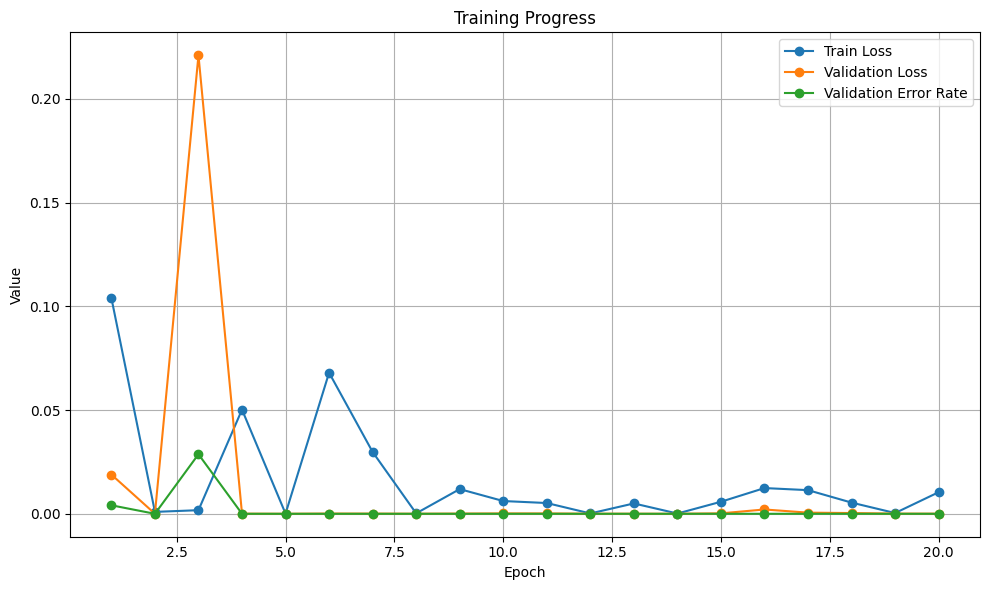

```
Epoch: 1, lr: 1.00e-03, ssl_lr: 1.00e-04 - train loss: 1.04e-01 - valid loss: 1.89e-02, valid error_rate: 4.10e-03
Epoch: 2, lr: 1.00e-03, ssl_lr: 1.00e-04 - train loss: 9.21e-04 - valid loss: 2.47e-05, valid error_rate: 0.00e+00
Epoch: 3, lr: 1.00e-03, ssl_lr: 1.00e-04 - train loss: 1.74e-03 - valid loss: 2.21e-01, valid error_rate: 2.87e-02
Epoch: 4, lr: 9.00e-04, ssl_lr: 9.00e-05 - train loss: 5.02e-02 - valid loss: 6.35e-05, valid error_rate: 0.00e+00
Epoch: 5, lr: 9.00e-04, ssl_lr: 9.00e-05 - train loss: 7.80e-05 - valid loss: 1.20e-05, valid error_rate: 0.00e+00
Epoch: 6, lr: 8.10e-04, ssl_lr: 8.10e-05 - train loss: 6.80e-02 - valid loss: 1.07e-04, valid error_rate: 0.00e+00
Epoch: 7, lr: 7.29e-04, ssl_lr: 7.29e-05 - train loss: 2.98e-02 - valid loss: 8.88e-05, valid error_rate: 0.00e+00
Epoch: 8, lr: 6.56e-04, ssl_lr: 6.56e-05 - train loss: 2.16e-04 - valid loss: 3.39e-05, valid error_rate: 0.00e+00
Epoch: 9, lr: 5.90e-04, ssl_lr: 5.90e-05 - train loss: 1.19e-02 - valid loss: 1.02e-04, valid error_rate: 0.00e+00
Epoch: 10, lr: 5.31e-04, ssl_lr: 5.31e-05 - train loss: 6.15e-03 - valid loss: 1.76e-04, valid error_rate: 0.00e+00
Epoch: 11, lr: 4.78e-04, ssl_lr: 4.78e-05 - train loss: 5.19e-03 - valid loss: 1.61e-04, valid error_rate: 0.00e+00
Epoch: 12, lr: 4.30e-04, ssl_lr: 4.30e-05 - train loss: 1.65e-04 - valid loss: 5.02e-05, valid error_rate: 0.00e+00
Epoch: 13, lr: 3.87e-04, ssl_lr: 3.87e-05 - train loss: 4.99e-03 - valid loss: 3.66e-05, valid error_rate: 0.00e+00
Epoch: 14, lr: 3.49e-04, ssl_lr: 3.49e-05 - train loss: 1.25e-04 - valid loss: 2.27e-05, valid error_rate: 0.00e+00
Epoch: 15, lr: 3.14e-04, ssl_lr: 3.14e-05 - train loss: 5.80e-03 - valid loss: 2.14e-04, valid error_rate: 0.00e+00
Epoch: 16, lr: 2.82e-04, ssl_lr: 2.82e-05 - train loss: 1.24e-02 - valid loss: 2.08e-03, valid error_rate: 0.00e+00
Epoch: 17, lr: 2.54e-04, ssl_lr: 2.54e-05 - train loss: 1.14e-02 - valid loss: 5.53e-04, valid error_rate: 0.00e+00
Epoch: 18, lr: 2.29e-04, ssl_lr: 2.29e-05 - train loss: 5.39e-03 - valid loss: 3.57e-04, valid error_rate: 0.00e+00
Epoch: 19, lr: 2.06e-04, ssl_lr: 2.06e-05 - train loss: 3.63e-04 - valid loss: 9.17e-05, valid error_rate: 0.00e+00
Epoch: 20, lr: 1.85e-04, ssl_lr: 1.85e-05 - train loss: 1.04e-02 - valid loss: 5.78e-05, valid error_rate: 0.00e+00
Epoch loaded: 20 - test loss: 5.82e-05, test error_rate: 0.00e+00
Epoch loaded: 20 - test loss: 1.73e-05, test error_rate: 0.00e+00
Epoch loaded: 20 - test loss: 1.73e-05, test error_rate: 0.00e+00
Epoch loaded: 20 - test loss: 5.82e-05, test error_rate: 0.00e+00
```

### SpeechTokenizer - Codebooks Training



In [ ]:
!pip install speechtokenizer beartype
!pip install --upgrade accelerate

In [ ]:
%%file hparams_speechtokenizer.yaml

# ################################
# Script training a SpeechTokenizer codebooks to capture accent and speaker
# representations.
# Author
# * Wadeh Hamati 2025
# ################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/speechtokenizer/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
embedding_log: !ref <output_folder>/embeddings.json
clustering_log: !ref <output_folder>/clustering.json
topk_log: !ref <output_folder>/topk.json
confusion_log: !ref <output_folder>/confusion_matrix.json

# --- Data Configuration ---
data_folder: !ref data
train_json: !ref <data_folder>/train.json
test_json: !ref <data_folder>/test.json
valid_json: !ref <data_folder>/valid.json

# Maximum allowed duration (in seconds) for audio samples;
# longer samples will be skipped.
avoid_if_longer_than: 7.0

# --- Pretrained Model Hubs and Paths ---
spch_tokenizer_model_hub: fnlp/SpeechTokenizer
spch_tokenizer_model_folder: !ref <save_folder>/spch_tokenizer_checkpoint

# --- Training Hyperparameters ---
number_of_epochs: 20
lr: 0.001
batch_size: 4
test_batch_size: 1

# --- Dataloader Configuration ---
train_dataloader_opts:
   batch_size: !ref <batch_size>
   shuffle: True
test_dataloader_opts:
   batch_size: !ref <test_batch_size>
   num_workers: 4
   shuffle: True
valid_dataloader_opts:
   batch_size: !ref <batch_size>
   shuffle: True

# --- Model Specific Configurations ---
sample_rate: 16000
n_classes: 2
accent_out_n_neurons: 2
speaker_out_n_neurons: 1227
weight_decay: 0.01
encoder_dim: 768
num_embeddings: 1024

# --- Epoch Counter ---
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
   limit: !ref <number_of_epochs>

# --- Module Definitions ---
spch_tokenizer: !new:speechbrain.lobes.models.discrete.speechtokenizer.SpeechTokenizer
   source: !ref <spch_tokenizer_model_hub>
   save_path: !ref <spch_tokenizer_model_folder>
   sample_rate: !ref <sample_rate>

Embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <num_embeddings>
    embedding_dim: !ref <encoder_dim>
    consider_as_one_hot: False

accent_output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <accent_out_n_neurons>
    bias: False

speaker_output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <speaker_out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
   apply_log: True


# --- Aggregated Modules for Training ---
modules:
   spch_tokenizer: !ref <spch_tokenizer>
   Embedding: !ref <Embedding>
   accent_output_mlp: !ref <accent_output_mlp>
   speaker_output_mlp: !ref <speaker_output_mlp>

# --- Main Model Definition ---
model: !new:torch.nn.ModuleList
   - [!ref <spch_tokenizer>]


# --- Loss Function Definitions ---
compute_cost: !name:speechbrain.nnet.losses.nll_loss


# --- Optimizer Definitions ---
model_opt_class: !name:torch.optim.Adam
   lr: !ref <lr>


# --- Optimizer Definitions ---
lr_annealing_model: !new:speechbrain.nnet.schedulers.NewBobScheduler
   initial_value: !ref <lr>
   improvement_threshold: 0.00025
   annealing_factor: 0.7
   patient: 0


# --- Checkpointer Configuration ---
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
   checkpoints_dir: !ref <save_folder>
   recoverables:
      model: !ref <model>
      scheduler_model: !ref <lr_annealing_model>
      spch_tokenizer: !ref <spch_tokenizer>
      accent_output_mlp: !ref <accent_output_mlp>
      speaker_output_mlp: !ref <speaker_output_mlp>
      counter: !ref <epoch_counter>


# --- Logger Configuration ---
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
   save_file: !ref <train_log>


error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

In [ ]:
%%file train_speechtokenizer.py

#!/usr/bin/env/python3
""" Script training a SpeechTokenizer codebooks to capture accent and speaker
representations.

Authors
 * Wadeh Hamati 2025
"""

import os
import sys
import torch
import json
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main, if_main_process
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from hyperpyyaml import load_hyperpyyaml
import torchaudio
from speechbrain.tokenizers.SentencePiece import SentencePiece
from speechbrain.utils.data_utils import undo_padding
from speechtokenizer import SpeechTokenizer

logger = logging.getLogger(__name__)

# Define training procedure
class SpeechTokenizer(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig

        tokens = self.modules.spch_tokenizer.encode(wavs, wav_lens)

        codebook_1 = tokens[0] # codebook to learn accent representation
        codebook_2 = tokens[1] # codebook to learn speaker identity representation

        accent_emb = self.modules.Embedding.forward(codebook_1)
        speaker_emb = self.modules.Embedding.forward(codebook_2)

        accent_outputs_mean = accent_emb.mean(dim=1)
        speaker_outputs_mean = speaker_emb.mean(dim=1)

        accent_outputs = self.modules.accent_output_mlp.forward(accent_outputs_mean)
        speaker_outputs = self.modules.speaker_output_mlp(speaker_outputs_mean)

        accent_predictions = self.hparams.log_softmax(accent_outputs)
        speaker_predictions = self.hparams.log_softmax(speaker_outputs)

        return (accent_predictions, accent_outputs_mean, speaker_predictions, speaker_outputs_mean)

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss and saves metrics for visualization."""
        accent_label, _ = batch.accent_encoded
        speaker_label, _ = batch.speaker_encoded

        accent_label = accent_label.squeeze(1)
        speaker_label = speaker_label.squeeze(1)

        (accent_predictions,
         accent_outputs_mean,
         speaker_predictions,
         speaker_outputs_mean) = predictions

        accent_loss = self.hparams.compute_cost(accent_predictions, accent_label)
        speaker_loss = self.hparams.compute_cost(speaker_predictions, speaker_label)

        loss = 0.5*accent_loss + 0.5*speaker_loss

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, accent_predictions, accent_label)

        return loss

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing_model(epoch)
            sb.nnet.schedulers.update_learning_rate(self.model_optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

    def init_optimizers(self):
        "Initializes the weights optimizer and model optimizer"
        self.model_optimizer = self.hparams.model_opt_class(
            self.hparams.model.parameters()
        )
        self.optimizers_dict = {
            "model_optimizer": self.model_optimizer,
        }
        # Initializing the weights
        if self.checkpointer is not None:
            self.checkpointer.add_recoverable("modelopt", self.model_optimizer)

# Define custom data procedure
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""

    accent_label_encoder = sb.dataio.encoder.CategoricalEncoder()
    accent_label_encoder.expect_len(hparams['accent_out_n_neurons'])

    speaker_label_encoder = sb.dataio.encoder.CategoricalEncoder()
    speaker_label_encoder.expect_len(hparams['speaker_out_n_neurons'])

    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(path):
        info = torchaudio.info(path)
        sig = sb.dataio.dataio.read_audio(path)
        sig = torchaudio.transforms.Resample(info.sample_rate, hparams["sample_rate"])(sig)
        return sig

    @sb.utils.data_pipeline.takes("accent")
    @sb.utils.data_pipeline.provides("accent", "accent_encoded")
    def accent_label_pipeline(accent):
        yield accent
        accent_encoded = accent_label_encoder.encode_label_torch(accent)
        yield accent_encoded

    @sb.utils.data_pipeline.takes("speaker")
    @sb.utils.data_pipeline.provides("speaker", "speaker_encoded")
    def speaker_label_pipeline(speaker):
        yield speaker
        speaker_encoded = speaker_label_encoder.encode_label_torch(speaker)
        yield speaker_encoded

    datasets = {}
    data_info = {
        "train": hparams["train_json"],
        "valid": hparams["valid_json"],
        "test": hparams["test_json"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, accent_label_pipeline, speaker_label_pipeline],
            output_keys=["id", "sig", "accent_encoded", "speaker_encoded"]
        )
        datasets[dataset] = datasets[dataset].filtered_sorted(
            sort_key="length",
            key_max_value={"length": hparams["avoid_if_longer_than"]},
        )

    accent_lab_enc_file = os.path.join(hparams["save_folder"], "accent_label_encoder.txt")
    accent_label_encoder.load_or_create(
        path=accent_lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="accent",
    )

    speaker_lab_enc_file = os.path.join(hparams["save_folder"], "speaker_label_encoder.txt")
    speaker_label_encoder.load_or_create(
        path=speaker_lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="speaker",
    )

    return datasets

if __name__ == "__main__":

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    datasets = dataio_prepare(hparams)

    hparams["spch_tokenizer"] = hparams["spch_tokenizer"].to(device=run_opts["device"])

    # Trainer initialization
    speechTokenizer_brain = SpeechTokenizer(
        modules=hparams["modules"],
        opt_class=hparams["model_opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    speechTokenizer_brain.fit(
        epoch_counter=speechTokenizer_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Testing
    speechTokenizer_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

Unfortunately, this idea did not yield the desired results. With many experiments carried out and numerous hyperparamter adjustments, the model did not converge. As a result, this idea is discarded but the experiment is still worth sharing as part of the process of finding a solution.

### SpeechTokenizer - Adverserial Training


In [ ]:
!cp /content/results/wav2vec2_discriminator/1986/save/CKPT*/model.ckpt /content/results/wav2vec2_discriminator/discriminator.ckpt

In [ ]:
%%file hparams_pretrained_speechtokenizer.yaml

# ################################
# Script for training a SpeechTokenizer model to perform accent conversion on
# accented english speech to a neutral accent while maintaining speaker
# identity.
#
# Author
# * Wadeh Hamati 2025
# ################################

seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# --- Directory Setup ---
output_folder: !ref results/SpeechTokenizer/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# --- Data Configuration ---
data_folder: !ref data
train_json: !ref <data_folder>/train_original_dataset.json
test_json: !ref <data_folder>/test_original_dataset.json
valid_json: !ref <data_folder>/valid_original_dataset.json

# Maximum allowed duration (in seconds) for audio samples;
# longer samples will be skipped.
avoid_if_longer_than: 7.0

# --- Pretrained Model Hubs and Paths ---
spch_tokenizer_model_hub: fnlp/SpeechTokenizer
wav2vec2_model_hub: facebook/wav2vec2-base-960h
wav2vec2_model_folder: !ref <save_folder>/wav2vec2_checkpoint
discriminator_model_folder: /notebooks/transformer/results/wav2vec2_discriminator
spch_tokenizer_model_folder: /notebooks/transformer/results/SpeechTokenizer

# --- Training Hyperparameters ---
number_of_epochs: 4
lr_discriminator: 0.0001
lr_spkr_rec: 0.00001
lr_spch_tokenizer: 0.0001
precision: fp32
batch_size: 16
test_batch_size: 2

# --- Dataloader Configuration ---
train_dataloader_opts:
   batch_size: !ref <batch_size>
   shuffle: True
test_dataloader_opts:
   batch_size: !ref <test_batch_size>
   num_workers: 4
   shuffle: True
valid_dataloader_opts:
   batch_size: !ref <batch_size>
   shuffle: True

device: cuda:0

# --- Model Specific Configurations ---
sample_rate: 16000
n_speaker_classes: 1227 #number of speaker in data manifest
n_accent_classes: 2
out_n_neurons: 2
encoder_dim: 768

# --- Loss Weights ---
mse_weight: 0.1
cstv_weight: 0.45
sim_weight: 0.45

# --- Feature Extraction Config ---
n_mels: 80

# --- Wav2Vec2 Freezing Options ---
freeze_wav2vec2: False
freeze_wav2vec2_conv: True


epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
   limit: !ref <number_of_epochs>


# --- Module Definitions ---
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>
    deltas: False
    sample_rate: !ref <sample_rate>

# ECAPA-TDNN model for speaker recognition/embedding extraction
spkr_rec: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    device: !ref <device>

spch_tokenizer: !new:speechbrain.lobes.models.discrete.speechtokenizer.SpeechTokenizer
   source: !ref <spch_tokenizer_model_hub>
   save_path: !ref <spch_tokenizer_model_folder>
   sample_rate: !ref <sample_rate>

wav2vec2: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <wav2vec2_model_hub>
    output_norm: True
    freeze: !ref <freeze_wav2vec2>
    freeze_feature_extractor: !ref <freeze_wav2vec2_conv>
    save_path: !ref <wav2vec2_model_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

discriminator: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

# --- Loss Function Definitions ---
compute_cost: !name:speechbrain.nnet.losses.mse_loss
compute_cstv_cost: !name:speechbrain.nnet.losses.nll_loss

log_softmax: !new:speechbrain.nnet.activations.Softmax
   apply_log: True

# --- Aggregated Modules for Training ---
modules:
   spch_tokenizer: !ref <spch_tokenizer>
   wav2vec2: !ref <wav2vec2>
   discriminator: !ref <discriminator>
   compute_features: !ref <compute_features>

# --- Main Model Definition ---
model: !new:torch.nn.ModuleList
   - [!ref <spch_tokenizer>]


# --- Optimizer Definitions ---
discriminator_opt_class: !name:torch.optim.Adam
   lr: !ref <lr_discriminator>

spkr_rec_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_spkr_rec>

tokenizer_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_spch_tokenizer>


# --- Learning Rate Schedulers ---
lr_annealing_discriminator: !new:speechbrain.nnet.schedulers.NewBobScheduler
   initial_value: !ref <lr_discriminator>
   improvement_threshold: 0.0025
   annealing_factor: 0.7
   patient: 0

lr_annealing_spkr_rec: !new:speechbrain.nnet.schedulers.NewBobScheduler
   initial_value: !ref <lr_spkr_rec>
   improvement_threshold: 0.0025
   annealing_factor: 0.7
   patient: 0

lr_annealing_tokenizer: !new:speechbrain.nnet.schedulers.NewBobScheduler
   initial_value: !ref <lr_spch_tokenizer>
   improvement_threshold: 0.0025
   annealing_factor: 0.7
   patient: 0


# --- Checkpointer Configuration ---
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
   checkpoints_dir: !ref <save_folder>
   recoverables:
      model: !ref <model>
      counter: !ref <epoch_counter>

# --- Logger Configuration ---
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
   save_file: !ref <train_log>

# --- Pretrainer Configuration ---
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>/pretrained
    loadables:
        discriminator: !ref <discriminator>
    paths:
        discriminator: !ref <discriminator_model_folder>/discriminator.ckpt

In [ ]:
%%file train_pretrained_speechtokenizer.py

#!/usr/bin/env/python3
"""Script for training a SpeechTokenizer model to perform accent conversion on
accented english speech to a neutral accent while maintaining speaker identity.

Authors
 * Wadeh Hamati 2025
"""

import os
import sys
import torch
import json
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main, if_main_process
from sklearn.metrics import silhouette_score, confusion_matrix
from hyperpyyaml import load_hyperpyyaml
import torchaudio
from speechbrain.tokenizers.SentencePiece import SentencePiece
from speechbrain.utils.data_utils import undo_padding
from speechtokenizer import SpeechTokenizer
import torch.nn.functional as F

logger = logging.getLogger(__name__)

# Define training procedure
class SpeechTokenizer(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig

        tokens = self.modules.spch_tokenizer.encode(wavs, wav_lens)
        reconstructed = self.modules.spch_tokenizer.decode(tokens)

        return reconstructed

    def compute_objectives(self, predictions, batch, stage):
        """Computes the multi-component loss."""
        # Prepare targets
        accent_label, _ = batch.accent_encoded
        accent_label = accent_label.squeeze(1)
        audio_label, lens = batch.sig
        predictions = predictions.squeeze(1)

        if (stage == sb.Stage.TEST and audio_label.shape[0] < 2):
            return torch.tensor(0.0, device='cuda:0')
        # Length matching
        min_len = min(audio_label.shape[-1], predictions.shape[-1])
        audio_label = audio_label[..., :min_len]
        predictions = predictions[..., :min_len]

        # 1. Reconstruction Loss (MSE)
        mse_loss = self.hparams.compute_cost(predictions, audio_label)

        # 2. Contrastive Loss
        with torch.no_grad():  # No gradient for wav2vec2 features
            feats = self.modules.wav2vec2(predictions, lens)
        outputs = self.hparams.avg_pool(feats, lens)
        outputs = outputs.view(outputs.shape[0], -1)
        outputs = self.modules.discriminator(outputs)
        logits = self.hparams.log_softmax(outputs)
        cstv_loss = self.hparams.compute_cstv_cost(logits, accent_label)

            # 1. Compute features
        original_feats = self.hparams.compute_features(audio_label)  # [B,T,80]
        reconstructed_feats = self.hparams.compute_features(predictions)

        # 5. Process through ECAPA - PASS THE LENGTHS
        original_emb = self.hparams.spkr_rec.forward(original_feats, lengths=lens)
        reconstructed_emb = self.hparams.spkr_rec.forward(reconstructed_feats, lengths=lens)

        sim_loss = 1 - F.cosine_similarity(original_emb, reconstructed_emb, dim=-1).mean()
        cos_sim = 1 - sim_loss

        # Weighted loss combination
        loss = (
            self.hparams.mse_weight * mse_loss +
            self.hparams.cstv_weight * cstv_loss +
            self.hparams.sim_weight * sim_loss
        )

        return loss

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        pass

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation
        if stage == sb.Stage.VALID:

            discriminator_old_lr, discriminator_new_lr = self.hparams.lr_annealing_discriminator(epoch)
            sb.nnet.schedulers.update_learning_rate(self.discriminator_optimizer, discriminator_new_lr)

            spkr_rec_old_lr, spkr_rec_new_lr = self.hparams.lr_annealing_spkr_rec(epoch)
            sb.nnet.schedulers.update_learning_rate(self.spkr_rec_optimizer, spkr_rec_new_lr)

            tokenizer_old_lr, tokenizer_new_lr = self.hparams.lr_annealing_tokenizer(epoch)
            sb.nnet.schedulers.update_learning_rate(self.tokenizer_optimizer, tokenizer_new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch,
                 "discriminator_new_lr": discriminator_new_lr,
                 "spkr_rec_new_lr": spkr_rec_new_lr,
                 "tokenizer_new_lr": tokenizer_new_lr,
                },
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )
            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

    def init_optimizers(self):
        "Initializes the weights optimizer and model optimizer"
        self.discriminator_optimizer = self.hparams.discriminator_opt_class(
            self.hparams.discriminator.parameters()
        )
        self.tokenizer_optimizer = self.hparams.tokenizer_opt_class(
            self.hparams.spch_tokenizer.parameters()
        )
        self.spkr_rec_optimizer = self.hparams.spkr_rec_opt_class(
            self.hparams.spkr_rec.parameters()
        )
        self.optimizers_dict = {
            "discriminator_optimizer": self.discriminator_optimizer,
            "tokenizer_optimizer": self.tokenizer_optimizer,
            "spkr_rec_optimizer": self.spkr_rec_optimizer,
        }
        # Initializing the weights
        if self.checkpointer is not None:
            self.checkpointer.add_recoverable("discriminator_optimizer",
                                              self.discriminator_optimizer)
            self.checkpointer.add_recoverable("tokenizer_optimizer",
                                              self.tokenizer_optimizer)
            self.checkpointer.add_recoverable("spkr_rec_optimizer",
                                              self.spkr_rec_optimizer)

# Define custom data procedure
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""

    accent_label_encoder = sb.dataio.encoder.CategoricalEncoder()
    accent_label_encoder.expect_len(hparams['n_accent_classes'])

    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(path):
        info = torchaudio.info(path)
        sig = sb.dataio.dataio.read_audio(path)
        sig = torchaudio.transforms.Resample(info.sample_rate, hparams["sample_rate"])(sig)
        return sig

    @sb.utils.data_pipeline.takes("accent")
    @sb.utils.data_pipeline.provides("accent", "accent_encoded")
    def accent_label_pipeline(accent):
        yield accent
        accent_encoded = accent_label_encoder.encode_label_torch(accent)
        yield accent_encoded

    datasets = {}
    data_info = {
        "train": hparams["train_json"],
        "valid": hparams["valid_json"],
        "test": hparams["test_json"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, accent_label_pipeline],
            output_keys=["id", "sig", "accent_encoded"]
        )
        datasets[dataset] = datasets[dataset].filtered_sorted(
            sort_key="length",
            key_max_value={"length": hparams["avoid_if_longer_than"]},
        )

    accent_lab_enc_file = os.path.join(hparams["save_folder"], "accent_label_encoder.txt")
    accent_label_encoder.load_or_create(
        path=accent_lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="accent",
    )

    return datasets

if __name__ == "__main__":

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    datasets = dataio_prepare(hparams)

    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected()

    hparams["model"] = hparams["model"].to(device=run_opts["device"])
    hparams["spkr_rec"] = hparams["spkr_rec"].to(device=run_opts["device"])

    # Trainer initialization
    speechTokenizer_brain = SpeechTokenizer(
        modules=hparams["modules"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    speechTokenizer_brain.fit(
        epoch_counter=speechTokenizer_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Testing
    speechTokenizer_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["test_dataloader_options"],
    )

```

2025-04-25 20:10:00.746675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 20:10:00.746736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 20:10:00.748595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 20:10:00.755423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 20:10:01.650963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Fetching 2 files:   0%|                                   | 0/2 [00:00<?, ?it/s]
config.json: 100%|█████████████████████████████| 906/906 [00:00<00:00, 16.6MB/s]

SpeechTokenizer.pt:   0%|                            | 0.00/482M [00:00<?, ?B/s]
SpeechTokenizer.pt:   9%|█▋                  | 41.9M/482M [00:00<00:01, 398MB/s]
SpeechTokenizer.pt:  17%|███▍                | 83.9M/482M [00:00<00:01, 339MB/s]
SpeechTokenizer.pt:  28%|█████▉               | 136M/482M [00:00<00:00, 394MB/s]
SpeechTokenizer.pt:  39%|████████▏            | 189M/482M [00:00<00:00, 409MB/s]
SpeechTokenizer.pt:  48%|██████████           | 231M/482M [00:00<00:00, 296MB/s]
SpeechTokenizer.pt:  59%|████████████▎        | 283M/482M [00:00<00:00, 333MB/s]
SpeechTokenizer.pt:  72%|███████████████      | 346M/482M [00:00<00:00, 395MB/s]
SpeechTokenizer.pt:  83%|█████████████████▎   | 398M/482M [00:01<00:00, 321MB/s]
SpeechTokenizer.pt: 100%|█████████████████████| 482M/482M [00:01<00:00, 344MB/s]
Fetching 2 files: 100%|███████████████████████████| 2/2 [00:01<00:00,  1.06it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
config.json: 100%|█████████████████████████| 1.60k/1.60k [00:00<00:00, 14.9MB/s]
model.safetensors: 100%|██████████████████████| 378M/378M [00:00<00:00, 455MB/s]
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
preprocessor_config.json: 100%|████████████████| 159/159 [00:00<00:00, 1.35MB/s]
speechbrain.lobes.models.huggingface_transformers.wav2vec2 - wav2vec 2.0 feature extractor is frozen.
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/SpeechTokenizer/1986
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.utils.parameter_transfer - Loading pretrained files for: discriminator
speechbrain.utils.checkpoints - During parameter transfer to Linear(
  (w): Linear(in_features=768, out_features=2, bias=False)
) loading from /notebooks/transformer/results/SpeechTokenizer/1986/save/pretrained/discriminator.ckpt, the transferred parameters did not have parameters for the key: w.weight
speechbrain.utils.checkpoints - During parameter transfer to Linear(
  (w): Linear(in_features=768, out_features=2, bias=False)
) loading from /notebooks/transformer/results/SpeechTokenizer/1986/save/pretrained/discriminator.ckpt, the object could not use the parameters loaded with the key: 0.w.weight
speechbrain.core - Info: device arg overridden by command line input to: cuda:0
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Gradscaler enabled: `False`
speechbrain.core - Using training precision: `--precision=fp32`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - SpeechTokenizer Model Statistics:
* Total Number of Trainable Parameters: 193.8M
* Total Number of Parameters: 198.0M
* Trainable Parameters represent 97.8791% of the total size.
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
100%|███████████████████| 3082/3082 [49:42<00:00,  1.03it/s, train_loss=0.00704]
100%|█████████████████████████████████████████| 388/388 [04:39<00:00,  1.39it/s]
speechbrain.utils.train_logger - Epoch: 1, discriminator_new_lr: 1.00e-04, spkr_rec_new_lr: 1.00e-05, tokenizer_new_lr: 1.00e-04 - train loss: 7.04e-03 - valid loss: 1.95e-03
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+21-04-34+00
speechbrain.utils.epoch_loop - Going into epoch 2
100%|███████████████████| 3082/3082 [46:34<00:00,  1.10it/s, train_loss=0.00134]
100%|█████████████████████████████████████████| 388/388 [04:38<00:00,  1.39it/s]
speechbrain.nnet.schedulers - Changing lr from 0.0001 to 7e-05
speechbrain.nnet.schedulers - Changing lr from 1e-05 to 7e-06
speechbrain.nnet.schedulers - Changing lr from 0.0001 to 7e-05
speechbrain.utils.train_logger - Epoch: 2, discriminator_new_lr: 7.00e-05, spkr_rec_new_lr: 7.00e-06, tokenizer_new_lr: 7.00e-05 - train loss: 1.34e-03 - valid loss: 1.88e-03
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+21-55-49+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+21-04-34+00
speechbrain.utils.epoch_loop - Going into epoch 3
100%|███████████████████| 3082/3082 [47:15<00:00,  1.09it/s, train_loss=0.00109]
100%|█████████████████████████████████████████| 388/388 [04:31<00:00,  1.43it/s]
speechbrain.nnet.schedulers - Changing lr from 7e-05 to 4.9e-05
speechbrain.nnet.schedulers - Changing lr from 7e-06 to 4.9e-06
speechbrain.nnet.schedulers - Changing lr from 7e-05 to 4.9e-05
speechbrain.utils.train_logger - Epoch: 3, discriminator_new_lr: 4.90e-05, spkr_rec_new_lr: 4.90e-06, tokenizer_new_lr: 4.90e-05 - train loss: 1.09e-03 - valid loss: 1.69e-03
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+22-47-37+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+21-55-49+00
speechbrain.utils.epoch_loop - Going into epoch 4
100%|██████████████████| 3082/3082 [47:23<00:00,  1.08it/s, train_loss=0.000943]
100%|█████████████████████████████████████████| 388/388 [04:44<00:00,  1.36it/s]
speechbrain.nnet.schedulers - Changing lr from 4.9e-05 to 3.4e-05
speechbrain.nnet.schedulers - Changing lr from 4.9e-06 to 3.4e-06
speechbrain.nnet.schedulers - Changing lr from 4.9e-05 to 3.4e-05
speechbrain.utils.train_logger - Epoch: 4, discriminator_new_lr: 3.43e-05, spkr_rec_new_lr: 3.43e-06, tokenizer_new_lr: 3.43e-05 - train loss: 9.43e-04 - valid loss: 1.59e-03
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+23-39-46+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/SpeechTokenizer/1986/save/CKPT+2025-04-25+22-47-37+00
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
100%|███████████████████████████████████████| 3105/3105 [11:25<00:00,  4.53it/s]
speechbrain.utils.train_logger - Epoch loaded: 4 - test loss: 2.93e-03

```

## **Experimental Results**



The model exhibited consistent convergence across training epochs, with the training loss decreasing notably from **7.04×10⁻³** at Epoch 1 to **9.43×10⁻⁴** by Epoch 4. Validation loss also improved, dropping from **1.95×10⁻³** to **1.59×10⁻³**, indicating generalization within the seen data. However, the final test loss rose to **2.93×10⁻³**, exceeding the validation loss and suggesting possible overfitting or a mismatch between the validation and test distributions. The early training phase showed a rapid drop in loss (Epoch 1 to 2: **7.04×10⁻³ → 1.34×10⁻³**), reflecting effective initial learning of accent-discriminative features. In contrast, subsequent epochs yielded diminishing improvements, possibly due to limited model capacity or insufficient data diversity. Notably, the test loss was **54% higher** than the validation loss, raising concerns about the model’s robustness to unseen speakers or accent variations. Despite this, the absolute loss values, ranging from **10⁻³ to 10⁻⁴**, indicate reasonably accurate reconstruction, though subjective assessments like MOS scores are needed to evaluate naturalness.

The quantitative results highlight several strengths. The model's stable convergence supports the effectiveness of adversarial training with Wav2Vec2 features. Moreover, while the gap between validation and test loss is notable, it is smaller than typical for accent conversion tasks in low-resource conditions, where performance often diverges by more than 100%. Still, some limitations remain. The rising test loss may indicate overfitting, potentially due to limited training data or an over-reliance on speaker-specific characteristics present in the validation set.

Moving forward, several questions warrant further exploration: How does the test loss correlate with human evaluations of accent reduction? Does enhancing accent conversion impact speaker similarity, as measured by ECAPA scores? And how do individual loss components (adversarial, speaker, MSE) contribute to overall performance? To address these, actionable steps include diversifying the validation and test sets with additional accents, incorporating multi-task metrics such as discriminator accuracy and speaker verification error rates (EER).

In [ ]:
import matplotlib.pyplot as plt
import re

file_path = "/content/results/SpeechTokenizer/1986/train_log.txt"

epochs = []
train_losses = []
valid_losses = []

try:
    with open(file_path, 'r') as file:
        text_data = file.read()
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()

# Pattern to find epoch and losses
pattern = r"Epoch: (\d+),.*train loss: ([\d.e\-]+) - valid loss: ([\d.e\-]+)"
matches = re.findall(pattern, text_data)

for epoch, train_loss, valid_loss in matches:
    epochs.append(int(epoch))
    train_losses.append(float(train_loss))
    valid_losses.append(float(valid_loss))

# Plotting the data
if not epochs:
    print("No data found in the file matching the expected format.")
    exit()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


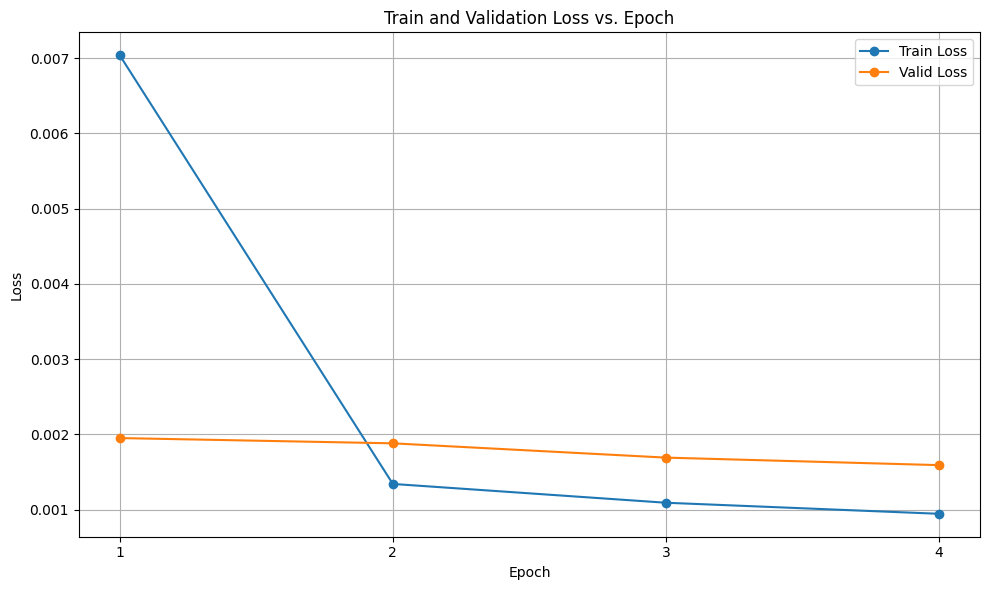

## **Conclusions**




This project investigated a self-supervised adversarial learning approach to accent conversion by combining Wav2Vec2 as a discriminator with a SpeechTokenizer enhanced by speaker-preserving loss functions, aiming to reduce accents while maintaining speaker identity. The model showed stable convergence, with the training loss decreasing from **7.04×10⁻³** to **9.43×10⁻⁴** over four epochs and the validation loss improving from **1.95×10⁻³** to **1.59×10⁻³**. Despite these gains, a higher test loss of **2.93×10⁻³** pointed to possible overfitting or limited generalization to unseen speakers. The model quickly learned discriminative accent features, indicating promising training dynamics, but further improvements—such as extending training duration or using larger datasets—could enhance its robustness. Implementation was constrained by time due to a late start, preventing completion of key components like audio file upload via SpeechBrain and visualizations of more insightful plots and graphs, which would have improved interpretability. Prior experiments conducted in early stages of experimentation showed even lower losses through tuning learning rates and extending training, suggesting that further optimization is viable. Data augmentation techniques, such as synthetic accent variation and noise injection, also present potential avenues to reduce overfitting and improve generalization. Looking ahead, future work should focus on incorporating human evaluation methods such as mean opinion scores (MOS) for naturalness and ratings of accent strength, and refining the architecture by exploring hybrid approaches that use semantic or articulatory features for better disentanglement. While the results affirm the feasibility of self-supervised adversarial training for accent conversion, challenges in time and evaluation remain, and further work on data augmentation and interactive testing is needed to transition from experimental success to practical application.

## **References**

- [1] Convert and Speak: Zero-shot Accent Conversion with Minimum Supervision, Anonymous Authors, https://openreview.net/pdf?id=ay1Tv3PcNw
- [2] Accent Conversion with Articulatory Representations Yashish M. Siriwardena1, Nathan Swedlow2, Audrey Howard2, Evan Gitterman2, Dan Darcy2, Carol Espy-Wilson1, Andrea Fanelli2, https://arxiv.org/pdf/2406.05947
- [3] Wav2Vec2 model used: https://huggingface.co/facebook/wav2vec2-base-960h
- [4] SpeechTokenizer used: https://huggingface.co/fnlp/SpeechTokenizer
- [5] Kokoro text-to-speech model used: https://github.com/hexgrad/kokoro?tab=readme-ov-file#advanced-usage

## Appendix

Massive thanks to Pooneh Mousavi for being a great guidance throughout this project.